In [1]:
import cv2
import glob
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio
from tqdm.auto import tqdm

from dataset import tfms_inference
from models import define_model

from utils import (
    rle_encode_less_memory,
    make_slices,
    load_image_from_slice,
    load_models,
)

from params import TEST_PATH

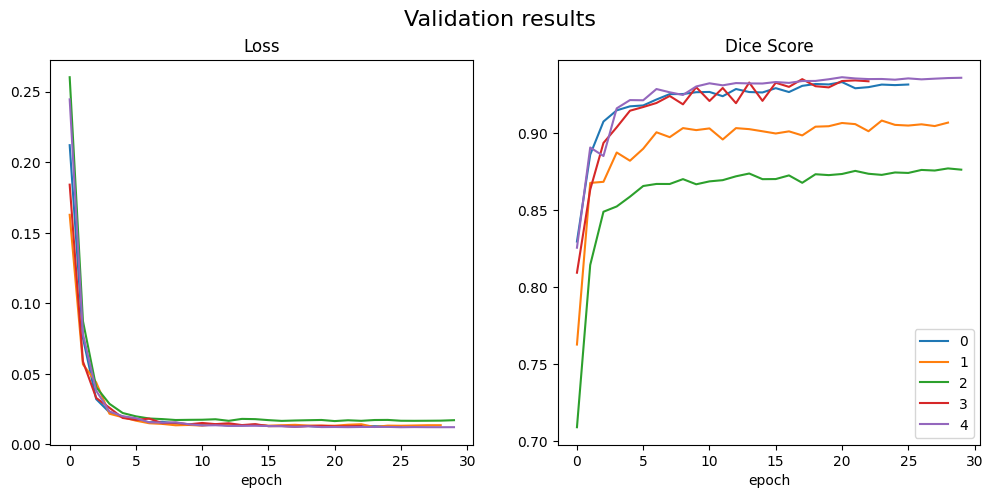

In [2]:
log_folder = '../logs/2023_06_17/0/'
results = glob.glob(log_folder + '*.txt')

result_df = pd.DataFrame()
for file in results:
    temp = pd.read_csv(file)
    result_df = pd.concat([temp ,result_df], axis=0)

result_df_wide = result_df.pivot(index='epoch', 
                                 columns=['fold', 'phase'], 
                                 values=['loss', 'dice'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(5):
    temp = result_df_wide['loss'][i]['valid']
    temp.plot(label=i, ax=axes[0])
    temp = result_df_wide['dice'][i]['valid']
    temp.plot(label=i, ax=axes[1])
axes[0].set_title('Loss')
axes[1].set_title('Dice Score')
plt.suptitle("Validation results", fontsize=16)
plt.legend()
plt.show()

---

In [3]:
log_folder = '../logs/2023_06_17/0/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
threshold = 0.5

In [4]:
class Config:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = json.load(open(log_folder + 'config.json', 'r'))
config = Config(**config)

In [6]:
def inference(model, image):
    with torch.inference_mode():
        out = model(image)
        preds = torch.sigmoid(out).detach().cpu().numpy()
    return preds

In [5]:
transform = tfms_inference(window=config.window, reduce=config.reduce)

In [7]:
model_state_dicts = glob.glob(log_folder + '*[034].pth')
model = define_model(
    decoder_name=config.decoder_name,
    encoder_name=config.encoder_name,
    encoder_weights=config.encoder_weights,
    num_classes=config.num_classes,
)
models = load_models(model, model_state_dicts)

In [8]:
test_files = glob.glob(str(TEST_PATH) + '/*.tiff')

In [9]:
sub = {}

for i, filepath in enumerate(test_files):
    filename = filepath.split('/')[-1][:-5]
    print(f"Predicting {filename}...")

    dataset = rasterio.open(filepath)
    slices = make_slices(dataset, window=config.window, overlap=0)
    preds = np.zeros(dataset.shape, dtype=np.uint8)

    batch_images = []
    batch_coords = []

    for idx, slice in enumerate(tqdm(slices), 1):
        image = load_image_from_slice(dataset, slice, window_size=config.window)
        if image.sum() == 0:
            continue
        image = transform(image=image)['image']
        batch_images.append(image)
        batch_coords.append(slice)

        if (len(batch_images) == batch_size
            or idx == len(slices)):
            batch = torch.stack(batch_images)
            pred = None

            for model in models:
                if pred is None:
                    pred = inference(model, batch.to(device))
                else:
                    pred += inference(model, batch.to(device))
            pred /= len(models)
            
            for p, coords in zip(pred, batch_coords):
                p = cv2.resize(p.squeeze(), (config.window, config.window))
                preds[coords[0]:coords[1], coords[2]:coords[3]] = (p>threshold).astype(np.uint8)
            
            batch_images = []
            batch_coords = []
            torch.cuda.empty_cache()

    sub[i] = {'img': filename, 'pixels': rle_encode_less_memory(preds)}

Predicting 57512b7f1...


/home/rg_im/anaconda3/envs/torch/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/1419 [00:00<?, ?it/s]

Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile width 337, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile length 259, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile width 337, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile length 259, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile width 168, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile length 129, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile width 168, convert file
Warning 1: ../data/test/57512b7f1.tiff:Nonstandard tile length 129, convert file


Predicting 2ec3f1bb9...


  0%|          | 0/1128 [00:00<?, ?it/s]

Predicting aa05346ff...


  0%|          | 0/1457 [00:00<?, ?it/s]

Warning 1: ../data/test/aa05346ff.tiff:Nonstandard tile width 369, convert file
Warning 1: ../data/test/aa05346ff.tiff:Nonstandard tile width 369, convert file
Warning 1: ../data/test/aa05346ff.tiff:Nonstandard tile width 184, convert file
Warning 1: ../data/test/aa05346ff.tiff:Nonstandard tile length 120, convert file
Warning 1: ../data/test/aa05346ff.tiff:Nonstandard tile width 184, convert file
Warning 1: ../data/test/aa05346ff.tiff:Nonstandard tile length 120, convert file


Predicting 3589adb90...


  0%|          | 0/638 [00:00<?, ?it/s]

Predicting d488c759a...


  0%|          | 0/1334 [00:00<?, ?it/s]

Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile width 453, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile width 453, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile width 226, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile length 364, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile width 226, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile length 364, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile width 113, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile length 182, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile width 113, convert file
Warning 1: ../data/test/d488c759a.tiff:Nonstandard tile length 182, convert file


In [15]:
submission = pd.DataFrame.from_dict(sub).T
submission.to_csv(log_folder + 'submission.csv', index=False)
submission

,img,pixels
0,57512b7f1,261973579 3 262006816 9 262040053 16 262073291...
1,2ec3f1bb9,60738328 2 60762303 30 60786285 42 60810269 52...
2,aa05346ff,52918146 14 52948855 34 52979566 49 53010280 5...
3,3589adb90,68600095 1 68629519 19 68658948 32 68688378 44...
4,d488c759a,466887593 313 466934253 313 466980913 313 4670...
